# Import function library

In [1]:
%run yulesimon-lib.ipynb

# CONSTANTS

In [2]:
N_RANGE=[11]; RANDOM_STATES=[17]

# N_RANGE=[5,8,11]; RANDOM_STATES=[0, 17]
# N_RANGE=range(5, 12); RANDOM_STATES=[0, 3, 5, 8, 11, 16, 17, 20, 21, 24]

trials_out = {}

PLOT_LEARNING_CURVES = True
PLOT_INPUT = True

RUN_DNN = True
RUN_DNN_ZEROS = True
RUN_DNN_WIN_SLIDING_AVG = True
RUN_DNN_WIN_SLIDING_AVG_ZEROS = True
RUN_DNN_SLIDING_SUM = True
RUN_DNN_SLIDING_SUM_ZEROS = True
RUN_DNN_WIN = True
RUN_DNN_WIN_ZEROS = True
RUN_CNN = True
RUN_CNN_ZEROS = True
RUN_CNNM = True


In [3]:
def debug_summary(trial):
    if PLOT_INPUT:
        trial_plot_input(trial['input_sample'])
    if PLOT_LEARNING_CURVES:
        trial_plot_learning_curves(trial)

# helper function to plot learning curves for the given trial output
def trial_plot_learning_curves(trial):
    history_path = '{}.history'.format(trial['base_path'])
    history = pickle.load(open(history_path, 'rb'))
    plot_learning_curves(history)

# helper function to plot input shape
def trial_plot_input(x):
    z = x.flatten()
    _ = plt.scatter(range(len(z)), z, s=5, color="blue", label="original")

# DNN

Processing...

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.01082

loss: 0.00385962
val_loss: 0.00020544
CPU times: user 1min 6s, sys: 5.9 s, total: 1min 11s
Wall time: 32.4 s


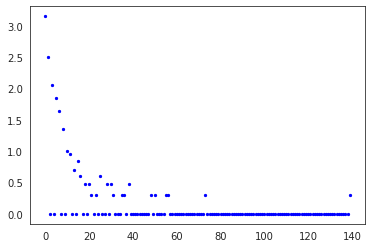

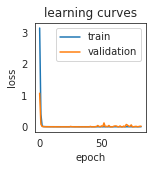

In [4]:
%%time
if RUN_DNN:
    nn = 'DNN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])


# DNN zeros

Processing...

input.shape: (10000, 150)
N: 2048  avg_sqrt_mse = 0.01026

loss: 0.00388884
val_loss: 0.00025243
CPU times: user 59.9 s, sys: 5.09 s, total: 1min 4s
Wall time: 29.4 s


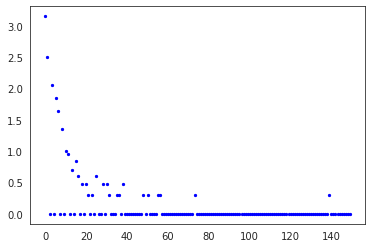

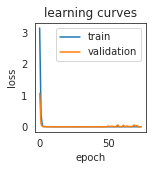

In [5]:
%%time
if RUN_DNN_ZEROS:
    nn = 'DNN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN sliding-avg test

In [6]:
X_moving_avg_test = np.array([ [1,2,3,4,5,6,7], [1,2,3,4,5,6,7] ])

print('X_moving_avg_test:')
print(X_moving_avg_test)

OUT_moving_avg_test, window_sizes = data_hstack_moving_avg(X_moving_avg_test)

print()
print('window_sizes:', window_sizes)

print()
print('OUT_moving_avg_test:')
print(OUT_moving_avg_test)

X_moving_avg_test:
[[1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]

window_sizes: [2, 4]

OUT_moving_avg_test:
[[1.  2.  3.  4.  5.  6.  7.  1.5 2.5 3.5 4.5 5.5 6.5 2.5 3.5 4.5 5.5]
 [1.  2.  3.  4.  5.  6.  7.  1.5 2.5 3.5 4.5 5.5 6.5 2.5 3.5 4.5 5.5]]


# DNN sliding-avg

Processing...

input.shape: (10000, 873)
N: 2048  avg_sqrt_mse = 0.00874

loss: 0.00366992
val_loss: 0.00011272
CPU times: user 5min 21s, sys: 24.8 s, total: 5min 46s
Wall time: 1min 44s


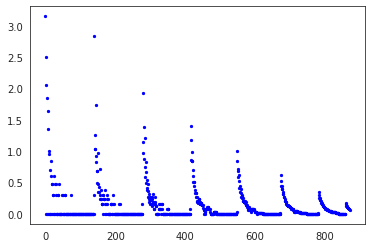

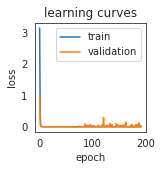

In [7]:
%%time
if RUN_DNN_WIN_SLIDING_AVG:
    nn = 'DNN_SLIDING_AVG'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN sliding-avg zeros

Processing...

input.shape: (10000, 953)
N: 2048  avg_sqrt_mse = 0.01250

loss: 0.00380323
val_loss: 0.00021943
CPU times: user 3min 35s, sys: 15 s, total: 3min 50s
Wall time: 1min 9s


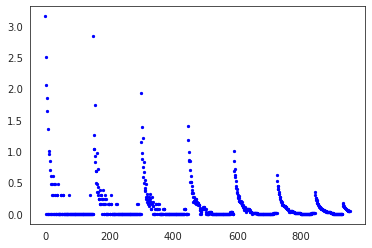

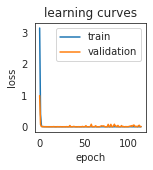

In [8]:
%%time
if RUN_DNN_WIN_SLIDING_AVG_ZEROS:
    nn = 'DNN_SLIDING_AVG'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN sliding-sum

Processing...

input.shape: (10000, 873)
N: 2048  avg_sqrt_mse = 0.02370

loss: 0.00403919
val_loss: 0.00088330
CPU times: user 2min 32s, sys: 11.2 s, total: 2min 43s
Wall time: 51.8 s


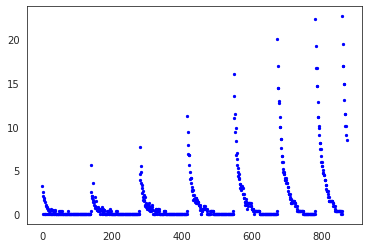

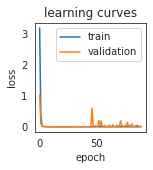

In [9]:
%%time
if RUN_DNN_SLIDING_SUM:
    nn = 'DNN_SLIDING_SUM'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN sliding-sum zeros

Processing...

input.shape: (10000, 953)
N: 2048  avg_sqrt_mse = 0.01955

loss: 0.00405012
val_loss: 0.00078284
CPU times: user 2min 19s, sys: 10.3 s, total: 2min 29s
Wall time: 46.9 s


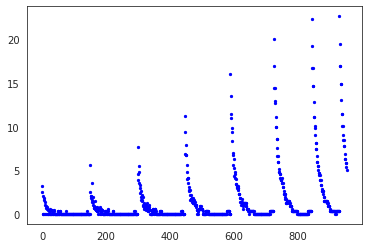

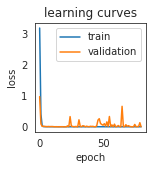

In [10]:
%%time
if RUN_DNN_SLIDING_SUM_ZEROS:
    nn = 'DNN_SLIDING_SUM_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN win test
Test to show that 'data_hstack_win_sum()' is working correctly

In [11]:
X_win_test = np.array([ [1,2,3,4,5,6,7], [1,2,3,4,5,6,7] ])

print('X_win_test:')
print(X_win_test)

OUT_win_test, window_sizes = data_hstack_win_sum(X_win_test)

print()
print('window_sizes:', window_sizes)

print()
print('OUT_win_test:')
print(OUT_win_test)

X_win_test:
[[1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]

window_sizes: [2, 4]

OUT_win_test:
[[ 1  2  3  4  5  6  7  3  7 11 10]
 [ 1  2  3  4  5  6  7  3  7 11 10]]


# DNN win

Processing...

input.shape: (10000, 277)
N: 2048  avg_sqrt_mse = 0.01282

loss: 0.00385094
val_loss: 0.00021193
CPU times: user 1min 22s, sys: 6.49 s, total: 1min 28s
Wall time: 35.7 s


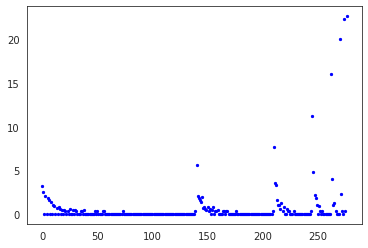

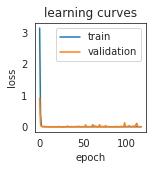

In [12]:
%%time
if RUN_DNN_WIN:
    nn = 'DNN_WIN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN win zeros

Processing...

input.shape: (10000, 296)
N: 2048  avg_sqrt_mse = 0.01420

loss: 0.00377371
val_loss: 0.00025945
CPU times: user 1min 30s, sys: 7.64 s, total: 1min 37s
Wall time: 38.5 s


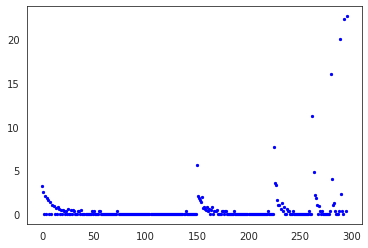

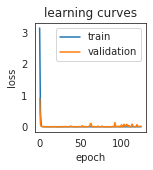

In [13]:
%%time
if RUN_DNN_WIN_ZEROS:
    nn = 'DNN_WIN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN

Processing...

input.shape: (10000, 140, 1)
N: 2048  avg_sqrt_mse = 0.00232

loss: 0.00000803
val_loss: 0.00000491
CPU times: user 1min 52s, sys: 6.48 s, total: 1min 59s
Wall time: 43.5 s


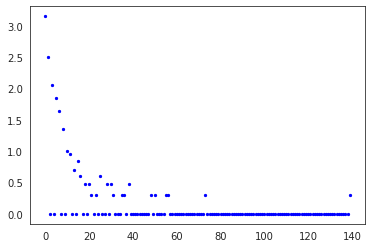

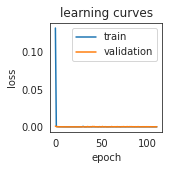

In [14]:
%%time
if RUN_CNN:
    nn = 'CNN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN zeros

Processing...

input.shape: (10000, 150, 1)
N: 2048  avg_sqrt_mse = 0.00264

loss: 0.00000567
val_loss: 0.00000663
CPU times: user 1min 55s, sys: 6.68 s, total: 2min 2s
Wall time: 43.2 s


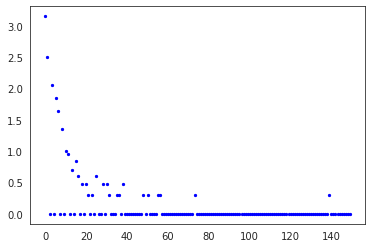

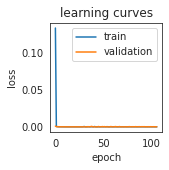

In [15]:
%%time
if RUN_CNN_ZEROS:
    nn = 'CNN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN multi-layer

Processing...

input.shape: (10000, 140, 1)
N: 2048  avg_sqrt_mse = 0.00106

loss: 0.00000497
val_loss: 0.00000089
CPU times: user 9min 27s, sys: 22.8 s, total: 9min 50s
Wall time: 2min 33s


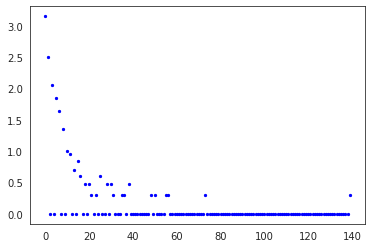

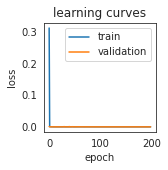

In [16]:
%%time
if RUN_CNNM:
    nn = 'CNNM'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=False, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN multi-layer + zeros

Processing...

input.shape: (10000, 150, 1)
N: 2048  avg_sqrt_mse = 0.00104

loss: 0.00000645
val_loss: 0.00000087
CPU times: user 11min 2s, sys: 26.4 s, total: 11min 28s
Wall time: 2min 54s


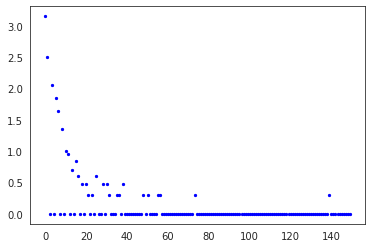

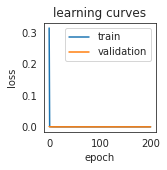

In [17]:
%%time
if RUN_CNNM:
    nn = 'CNNM_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, hstack_zeros=True, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# plot log(N) vs sqrt_mse (all trials)

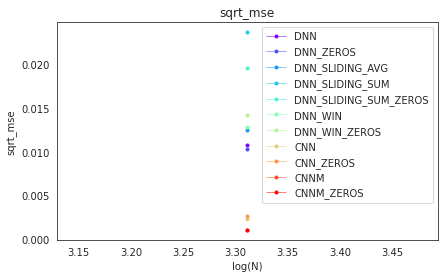

In [18]:
def plot_sqrt_mse(plot_std=False):
    
    plt.figure(figsize=(15, 4))
    
    ax1 = plt.subplot(1, 2, 1)

    ax1.set(title='sqrt_mse', xlabel='log(N)', ylabel='sqrt_mse')

    colors = iter(cm.rainbow(np.linspace(0, 1, len(trials_out))))

    for trial in trials_out:
        out = trials_out[trial]
        x = np.log10(out['a_N'])
        y = out['a_sqrt_mse']
        c = next(colors)
        ax1.plot(x, y, linewidth=0.5, c=c, marker='o', markersize=3, label=trial)
        if plot_std:
            std = out['a_std_abs_errors']
            ax1.fill_between(x, y - std, y + std, facecolor=colors[i], alpha=0.3)
    
    plt.legend(loc='upper right')

plot_sqrt_mse()


# print and save statistics (yulesimon.csv)

In [19]:
dict_list = []
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('N', t['a_N']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('sqrt_mse_{}'.format(trial), t['a_sqrt_mse']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('std_{}'.format(trial), t['a_std_abs_errors']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('avg_abs_error_{}'.format(trial), t['a_avg_abs_errors']))

df = pd.DataFrame(dict(dict_list))

df = df.set_index('N')

df.to_csv('yulesimon.csv', float_format='%.5f')

columns=[]
for t in trials_out:
    columns.append(('sqrt_MSE', trial))
for t in trials_out:
    columns.append(('STD', trial))
for t in trials_out:
    columns.append(('avg_abs_err', trial))

df.columns=pd.MultiIndex.from_tuples(columns)

print('err = y_test - y_pred')
df

err = y_test - y_pred


sqrt_MSE                                                         \
     CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS   
N                                                                        
2048   0.010823   0.010256   0.012505   0.023696   0.019549   0.012824   

                                                  ... avg_abs_err             \
     CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS  ...  CNNM_ZEROS CNNM_ZEROS   
N                                                 ...                          
2048   0.014203   0.002322   0.002644   0.001055  ...    0.007414   0.010518   

                                                                        \
     CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS   
N                                                                        
2048   0.019008   0.017099   0.009662   0.010664   0.001685   0.002332   

                            
     CNNM_ZEROS CNNM_ZEROS  
N                           
2048   0.000705   0.000705  

[1 rows x 33 columns]